# Техническое задание Маркетинг

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.

Цель - предсказать вероятность покупки в течение 90 дней.

## Описание данных

**apparel-purchases**

Данные о покупках клиентов по дням и по товарам. В каждой записи покупка определенного товара, его цена, количество штук.
В таблице есть списки идентификаторов, к каким категориям относится товар. Часто это вложенные категории (например автотовары-аксессуары-освежители), но также может включать в начале списка маркер распродажи или маркер женщинам/мужчинам.

- client_id - идентификатор клиента
- quantity - количество единиц товара
- price - цена товара
- category_ids - идентификаторы категорий
- date - дата покупки
- message_id - идентификатор сообщения из рассылки

**apparel-messages**

Рассылки, которые были отправлены клиентам из таблицы покупок.

- bulk_campaign_id - идентификатор рассылки
- client_id - идентификатор клиента
- message_id - идентификатор сообщения
- event - действие с сообщением (отправлено, открыто, покупка…)
- channel - канал рассылки
- date дата - действия
- created_at - дата-время полностью

**target**
- client_id - идентификатор клиента
- target клиент - совершил покупку в целевом периоде

---

## План работы

- [**Открыть файлы с данными, рассмотреть общую информацию о них. Создать признаки для анализа и обучения моделей.**](#chapter1)
- [**Проверить данные на наличие пропусков и аномалий, сделать необходимую предобработку данных.**](#chapter2)
- [**Построить диаграммы для всех признаков, провести исследовательский и корреляционный анализ.**](#chapter3)
- [**Подготовить данные для обучения моделей.**](#chapter4)
- [**Используя пайплайны, обучить несколько моделей, проварьировав их параметры, узнать лучшую модель. Обучить модель градиентного бустинга. Сравнить качество и время работы моделей.**](#chapter5)
- [**Сделать общий вывод.**](#chapter6)

---

## Загрузка данных и создание новых признаков <a class="anchor" id="chapter1"></a>

**Загружаю необходиые для работы библиотеки.**

In [1]:
import os #Для указания правильных путей к файлам
import pandas as pd #Для работы с датасетами
import matplotlib.pyplot as plt #Для работы с графиками
import numpy as np #Для работы с формулами и числами
import seaborn as sns #Для построения тепловых карт и ящиков с усами
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline #Для использования пайплайнов
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler, 
    RobustScaler) #Классы масштабирования количественных данных
from sklearn.compose import ColumnTransformer # Для работы с данными разного типа в одном наборе
from sklearn.metrics import roc_auc_score # Для работы с метрикой ROC-AUC
from sklearn.linear_model import LogisticRegression # Логистическая регрессия
from sklearn.tree import DecisionTreeClassifier  # Дерево решений
from sklearn.dummy import DummyClassifier #Для проверки адекватности модели
from phik import phik_matrix
from phik.report import plot_correlation_matrix #Для построения матрицы корреляции
from lightgbm import LGBMClassifier #Для градиентного бустинга
from time import time #Для работы со временем
RANDOM_STATE = 42 #Фиксирую случайное значение
pd.set_option('display.max_columns', None) #Для отображения всех столбцов

**Загружаю датасеты.**

In [2]:
pth1_1 = r'datasets\apparel-messages.csv' 
pth2_1 = '/datasets/apparel-messages.csv'
if os.path.exists(pth1_1):
    mess_1 = pd.read_csv(pth1_1)
elif os.path.exists(pth2_1):
    mess_1 = pd.read_csv(pth2_1)
else:
    print('Something is wrong')
mess_1.head(10)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52
5,4439,1515915625594606468,1515915625594606468-4439-6283411f277fc,open,email,2022-05-19,2022-05-19 01:04:11
6,4439,1515915625491810918,1515915625491810918-4439-6283411d9d299,open,email,2022-05-19,2022-05-19 01:19:54
7,4439,1515915625474219766,1515915625474219766-4439-628341212233a,open,email,2022-05-19,2022-05-19 01:23:43
8,4439,1515915625474219766,1515915625474219766-4439-628341212233a,click,email,2022-05-19,2022-05-19 01:24:16
9,4439,1515915625566741491,1515915625566741491-4439-6283412871599,open,email,2022-05-19,2022-05-19 01:31:06


In [3]:
pth1_2 = r'datasets\apparel-purchases.csv' 
pth2_2 = '/datasets/apparel-purchases.csv'
if os.path.exists(pth1_2):
    pur_1 = pd.read_csv(pth1_2)
elif os.path.exists(pth2_2):
    pur_1 = pd.read_csv(pth2_2)
else:
    print('Something is wrong')
pur_1.head(30)

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843
5,1515915625471640575,1,3499.0,"['2', '18', '258', '441']",2022-05-16,1515915625471640575-4301-627b661b67ac3
6,1515915625490211585,1,1699.0,"['2', '18', '341', '1311']",2022-05-16,1515915625490211585-4301-627b661843283
7,1515915625490739153,1,1999.0,"['2', '18', '123', '451']",2022-05-16,1515915625490739153-4172-626b943cc789b
8,1515915625491478747,1,999.0,"['5562', '5631', '5549', '667']",2022-05-16,1515915625491478747-4273-6274ceb769d59
9,1515915625491651493,1,699.0,"['5562', '5630', '5649', '678']",2022-05-16,1515915625491651493-4437-6282242f2a9e2


In [4]:
pth1_3 = r'datasets\apparel-target_binary.csv' 
pth2_3 = '/datasets/apparel-target_binary.csv'
if os.path.exists(pth1_3):
    tar_1 = pd.read_csv(pth1_3)
elif os.path.exists(pth2_3):
    tar_1 = pd.read_csv(pth2_3)
else:
    print('Something is wrong')
tar_1.head(10)

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0
5,1515915625468061514,0
6,1515915625468061877,0
7,1515915625468061975,0
8,1515915625468061994,0
9,1515915625468062158,0


**В предоставленных данных есть также агрегированные данные рассылок по дням и каналам рассылки. Рассмотрю их тоже.**

In [5]:
pth1_4 = r'datasets\full_campaign_daily_event.csv' 
pth2_4 = '/datasets/full_campaign_daily_event.csv'
if os.path.exists(pth1_4):
    daily_1 = pd.read_csv(pth1_4)
elif os.path.exists(pth2_4):
    daily_1 = pd.read_csv(pth2_4)
else:
    print('Something is wrong')
daily_1.head(10)

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,count_unsubscribe,nunique_click,nunique_complain,nunique_hard_bounce,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
5,2022-05-19,764,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
6,2022-05-19,766,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
7,2022-05-19,783,1,0,0,8,0,0,0,0,0,1,0,0,6,0,0,0,0,0,0,0,0,0
8,2022-05-19,817,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
9,2022-05-19,833,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [6]:
pth1_5 = r'datasets\full_campaign_daily_event_channel.csv' 
pth2_5 = '/datasets/full_campaign_daily_event_channel.csv'
if os.path.exists(pth1_5):
    daily_ch_1 = pd.read_csv(pth1_5)
elif os.path.exists(pth2_5):
    daily_ch_1 = pd.read_csv(pth2_5)
else:
    print('Something is wrong')
daily_ch_1.head(10)

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,count_unsubscribe_email,nunique_click_email,nunique_click_mobile_push,nunique_open_email,nunique_open_mobile_push,nunique_purchase_email,nunique_purchase_mobile_push,nunique_soft_bounce_email,nunique_subscribe_email,nunique_unsubscribe_email,count_hard_bounce_mobile_push,count_send_mobile_push,nunique_hard_bounce_mobile_push,nunique_send_mobile_push,count_hard_bounce_email,count_hbq_spam_email,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2022-05-19,764,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,2022-05-19,766,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,2022-05-19,783,1,0,8,0,0,0,0,0,0,1,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,2022-05-19,817,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,2022-05-19,833,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Данные открылись хорошо. Скорее всего я не буду использовать агрегированные данные по дням, поскольку они не дают информации по конкретным пользователям.**

In [7]:
mess_1.info()
pur_1.info()
tar_1.info()
daily_1.info()
daily_ch_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB
<class 'pandas.core.frame.DataFrame'>
Ra

**Приступлю к созданию признаков.**

**При первом взгляде на колонку message_id можно предположить, что id сообщения состоит из идентификатора клиента, идентификатора рассылки и уникального идентификатора самого сообщения. Проверю это.**

In [8]:
mess_1['m_0']=mess_1['message_id'].apply(lambda x: x.split('-')[0]).astype(np.int64)
mess_1['m_1']=mess_1['message_id'].apply(lambda x: x.split('-')[1]).astype(int)
mess_1['m_2']=mess_1['message_id'].apply(lambda x: x.split('-')[2])
mess_1.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at,m_0,m_1,m_2
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20,1515915625626736623,4439,6283415ac07ea
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34,1515915625490086521,4439,62834150016dd
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49,1515915625553578558,4439,6283415b36b4f
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20,1515915625553578558,4439,6283415b36b4f
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52,1515915625471518311,4439,628341570c133


**Проверю совпадение по номеру рассылки.**

In [9]:
mess_1_unr_1=mess_1.query('bulk_campaign_id!=m_1')
mess_1_unr_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   bulk_campaign_id  0 non-null      int64 
 1   client_id         0 non-null      int64 
 2   message_id        0 non-null      object
 3   event             0 non-null      object
 4   channel           0 non-null      object
 5   date              0 non-null      object
 6   created_at        0 non-null      object
 7   m_0               0 non-null      int64 
 8   m_1               0 non-null      int32 
 9   m_2               0 non-null      object
dtypes: int32(1), int64(3), object(6)
memory usage: 0.0+ bytes


**И по номеру клиента.**

In [10]:
mess_1_unr_2=mess_1.query('client_id!=m_0')
mess_1_unr_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   bulk_campaign_id  0 non-null      int64 
 1   client_id         0 non-null      int64 
 2   message_id        0 non-null      object
 3   event             0 non-null      object
 4   channel           0 non-null      object
 5   date              0 non-null      object
 6   created_at        0 non-null      object
 7   m_0               0 non-null      int64 
 8   m_1               0 non-null      int32 
 9   m_2               0 non-null      object
dtypes: int32(1), int64(3), object(6)
memory usage: 0.0+ bytes


**Действительно, полное совпадение.**

**Оставлю в датасете только те записи, которые содержат идентификаторы клиентов, для которых известен целевой признак.**

In [11]:
a=tar_1.client_id.unique()
mess_2=mess_1.query('client_id in @a').reset_index().set_index('index')
mess_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10950921 entries, 0 to 12739797
Data columns (total 10 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
 7   m_0               int64 
 8   m_1               int32 
 9   m_2               object
dtypes: int32(1), int64(3), object(6)
memory usage: 877.3+ MB


In [12]:
mess_2.columns

Index(['bulk_campaign_id', 'client_id', 'message_id', 'event', 'channel',
       'date', 'created_at', 'm_0', 'm_1', 'm_2'],
      dtype='object')

**Сделаю проверку на полные дубликаты сообщений.**

In [13]:
mess_2[mess_2\
       .duplicated(subset=['bulk_campaign_id', 'client_id', 'message_id', 'event', 'channel','date', 'created_at'], keep=False)]\
       .info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73474 entries, 964231 to 12739731
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   bulk_campaign_id  73474 non-null  int64 
 1   client_id         73474 non-null  int64 
 2   message_id        73474 non-null  object
 3   event             73474 non-null  object
 4   channel           73474 non-null  object
 5   date              73474 non-null  object
 6   created_at        73474 non-null  object
 7   m_0               73474 non-null  int64 
 8   m_1               73474 non-null  int32 
 9   m_2               73474 non-null  object
dtypes: int32(1), int64(3), object(6)
memory usage: 5.9+ MB


**Дубликатов, которые совпадают по всем параметрам с точностью до секунды отправки, не очень много, удалю их.**

In [14]:
mess_2=mess_2.drop_duplicates(keep='first')
mess_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10913197 entries, 0 to 12739797
Data columns (total 10 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
 7   m_0               int64 
 8   m_1               int32 
 9   m_2               object
dtypes: int32(1), int64(3), object(6)
memory usage: 874.2+ MB


**Для датасета с покупками также оставлю все записи с клиентами с известным целевым признаком.**

In [15]:
pur_2=pur_1.query('client_id in @a').reset_index().set_index('index')
pur_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 10.8+ MB


**Проведу аналогичную проверку по message_id.**

In [16]:
pur_2['m_0']=pur_2['message_id'].apply(lambda x: x.split('-')[0]).astype(np.int64)
pur_2['m_1']=pur_2['message_id'].apply(lambda x: x.split('-')[1]).astype(int)
pur_2['m_2']=pur_2['message_id'].apply(lambda x: x.split('-')[2])
pur_2.head()

,client_id,quantity,price,category_ids,date,message_id,m_0,m_1,m_2
index,,,,,,,,,
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,1515915625468169594,4301,627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d,1515915625468169594,4301,627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843,1515915625471138230,4437,6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843,1515915625471138230,4437,6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843,1515915625471138230,4437,6282242f27843


In [17]:
pur_2_unr_2=pur_2.query('client_id!=m_0')
pur_2_unr_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55683 entries, 28 to 202207
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   client_id     55683 non-null  int64  
 1   quantity      55683 non-null  int64  
 2   price         55683 non-null  float64
 3   category_ids  55683 non-null  object 
 4   date          55683 non-null  object 
 5   message_id    55683 non-null  object 
 6   m_0           55683 non-null  int64  
 7   m_1           55683 non-null  int32  
 8   m_2           55683 non-null  object 
dtypes: float64(1), int32(1), int64(3), object(4)
memory usage: 4.0+ MB


**Интересно, что здесь не наблюдается полного соответствия.**

In [18]:
pur_2_unr_2.head()

,client_id,quantity,price,category_ids,date,message_id,m_0,m_1,m_2
index,,,,,,,,,
28,1515915625684011633,1,3599.0,"['2', '18', '258', '441']",2022-05-16,1515915625491871768-3948-62592654633be,1515915625491871768,3948,62592654633be
29,1515915625730423268,1,1199.0,"['4', '28', '57', '431']",2022-05-16,1515915625490751146-4301-627b6626b6d85,1515915625490751146,4301,627b6626b6d85
30,1515915625776110064,1,1299.0,"['4', '31', '326', '505']",2022-05-16,1515915625468120968-4273-6274ceb961997,1515915625468120968,4273,6274ceb961997
31,1515915625776110064,1,2199.0,"['4', '28', '260', '420']",2022-05-16,1515915625468120968-4273-6274ceb961997,1515915625468120968,4273,6274ceb961997
372,1515915625535950983,1,399.0,"['2', '18', '267', '1330']",2022-05-17,1515915625498833429-4301-627b66176547d,1515915625498833429,4301,627b66176547d


In [19]:
b=pur_2_unr_2.client_id.unique()
len(b)

12373

In [20]:
mess_pur_unr=mess_2.query('client_id in @b').reset_index().set_index('index')
mess_pur_unr.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at,m_0,m_1,m_2
index,,,,,,,,,,
124,4439,1515915625639205490,1515915625639205490-4439-62834144e4b4c,open,email,2022-05-19,2022-05-19 04:51:54,1515915625639205490,4439,62834144e4b4c
142,4439,1515915625477744400,1515915625477744400-4439-62834143d5c61,open,email,2022-05-19,2022-05-19 05:24:29,1515915625477744400,4439,62834143d5c61
206,4439,1515915625468143544,1515915625468143544-4439-6283413a41b5b,click,email,2022-05-19,2022-05-19 06:02:36,1515915625468143544,4439,6283413a41b5b
222,4439,1515915625558838035,1515915625558838035-4439-6283411f387de,open,email,2022-05-19,2022-05-19 06:19:23,1515915625558838035,4439,6283411f387de
226,4439,1515915625468146523,1515915625468146523-4439-62834159385d1,open,email,2022-05-19,2022-05-19 06:28:36,1515915625468146523,4439,62834159385d1


In [21]:
pur_2_unr_2[pur_2_unr_2.client_id==1515915625639205490]

,client_id,quantity,price,category_ids,date,message_id,m_0,m_1,m_2
index,,,,,,,,,
162703,1515915625639205490,1,249.0,"['4', '28', '290', '424']",2023-08-11,1515915625889113202-13568-64c75fd53eb25,1515915625889113202,13568,64c75fd53eb25
162704,1515915625639205490,1,299.0,"['4', '28', '290', '424']",2023-08-11,1515915625889113202-13568-64c75fd53eb25,1515915625889113202,13568,64c75fd53eb25
162705,1515915625639205490,1,83.0,"['4', '27', '233', '462']",2023-08-11,1515915625889113202-13568-64c75fd53eb25,1515915625889113202,13568,64c75fd53eb25
162706,1515915625639205490,1,99.0,"['4', '27', '233', '462']",2023-08-11,1515915625889113202-13568-64c75fd53eb25,1515915625889113202,13568,64c75fd53eb25
162707,1515915625639205490,1,99.0,"['4', '27', '233', '462']",2023-08-11,1515915625889113202-13568-64c75fd53eb25,1515915625889113202,13568,64c75fd53eb25
162708,1515915625639205490,1,99.0,"['4', '27', '233', '462']",2023-08-11,1515915625889113202-13568-64c75fd53eb25,1515915625889113202,13568,64c75fd53eb25
162709,1515915625639205490,1,166.0,"['4', '28', '290', '547']",2023-08-11,1515915625889113202-13568-64c75fd53eb25,1515915625889113202,13568,64c75fd53eb25
162710,1515915625639205490,1,199.0,"['4', '28', '290', '547']",2023-08-11,1515915625889113202-13568-64c75fd53eb25,1515915625889113202,13568,64c75fd53eb25


In [22]:
pur_2_unr_2[pur_2_unr_2.m_0==1515915625639205490]

,client_id,quantity,price,category_ids,date,message_id,m_0,m_1,m_2
index,,,,,,,,,


**Я предположил, что не все покупатели совершали покупки после сообщения. И, возможно, поле с номером сообщения не допускало пропусков, поэтому заполнялось фиктивными данными со случайными номерами. Эти данные нужно будет обработать иначе.**

**Из списка категорий, так как это вложенные списки, я выделю только основную (первую) категорию.**

In [23]:
pur_2['f_category_id']=pur_2['category_ids'].apply(lambda x: x.split(",")[0][2:-1])
pur_2.f_category_id.unique()

array(['4', '2', '5562', '1', 'one', '', '5963', '3', '6060', '5'],
      dtype=object)

**Видно два необычных результата - пустая строка и 'one'. Рассмотрю их.**

In [24]:
pur_2.query('f_category_id=="one"')

,client_id,quantity,price,category_ids,date,message_id,m_0,m_1,m_2,f_category_id
index,,,,,,,,,,
14848,1515915625649908756,1,2499.0,[None],2022-06-17,1515915625649908756-4981-62ac2dbf52fad,1515915625649908756,4981,62ac2dbf52fad,one
32281,1515915625578652401,1,8.0,[None],2022-08-19,1515915625815834300-5922-62ff35494e05f,1515915625815834300,5922,62ff35494e05f,one
32282,1515915625578652401,1,8.0,[None],2022-08-19,1515915625815834300-5922-62ff35494e05f,1515915625815834300,5922,62ff35494e05f,one
32283,1515915625578652401,1,1.0,[None],2022-08-19,1515915625815834300-5922-62ff35494e05f,1515915625815834300,5922,62ff35494e05f,one
32284,1515915625578652401,1,1.0,[None],2022-08-19,1515915625815834300-5922-62ff35494e05f,1515915625815834300,5922,62ff35494e05f,one
...,...,...,...,...,...,...,...,...,...,...
61644,1515915625498389673,1,7.0,[None],2022-11-27,1515915625498389673-8033-637dbe2f79e78,1515915625498389673,8033,637dbe2f79e78,one
61835,1515915625642965095,1,7.0,[None],2022-11-27,1515915625642965095-8169-6381ebba96708,1515915625642965095,8169,6381ebba96708,one
61836,1515915625642965095,1,7.0,[None],2022-11-27,1515915625642965095-8169-6381ebba96708,1515915625642965095,8169,6381ebba96708,one


In [25]:
pur_2.query('f_category_id==""')

,client_id,quantity,price,category_ids,date,message_id,m_0,m_1,m_2,f_category_id
index,,,,,,,,,,
22153,1515915625558323436,1,1.0,[],2022-07-09,1515915625487742246-5335-62c7d2d1281c7,1515915625487742246,5335,62c7d2d1281c7,
22154,1515915625558323436,1,1.0,[],2022-07-09,1515915625487742246-5335-62c7d2d1281c7,1515915625487742246,5335,62c7d2d1281c7,
49215,1515915625474537721,1,7.0,[],2022-11-12,1515915625474537721-7803-636dfed5eb8b6,1515915625474537721,7803,636dfed5eb8b6,
53223,1515915625720375281,1,5.0,[],2022-11-13,1515915625720375281-7818-636f6ec29a382,1515915625720375281,7818,636f6ec29a382,
59056,1515915625867975448,1,7.0,[],2022-11-16,1515915625766044118-7879-63748749d81b5,1515915625766044118,7879,63748749d81b5,
...,...,...,...,...,...,...,...,...,...,...
201990,1515915625641742458,1,7.0,[],2024-02-16,1515915625766077627-14668-65cf5246bd490,1515915625766077627,14668,65cf5246bd490,
202068,1515915625955716904,1,7.0,[],2024-02-16,1515915625955716904-14668-65cf5252e767c,1515915625955716904,14668,65cf5252e767c,
202069,1515915625955716904,1,7.0,[],2024-02-16,1515915625955716904-14668-65cf5252e767c,1515915625955716904,14668,65cf5252e767c,


**Видно, что это неявные пропуски в данных, позже заполню их значением '0'.**

**Выделю признаки, которые я посчитал для себя важными, из этих двух датасетов.**

In [26]:
pur_imp=pur_2[['client_id', 'quantity', 'price', 'date', 'm_1', 'f_category_id', 'message_id']]
mess_imp=mess_2[['bulk_campaign_id', 'client_id', 'event', 'channel', 'date', 'message_id']]
pur_imp.client_id.nunique()

49849

In [27]:
mess_imp.client_id.nunique()

41982

**Видно, что действительно, не все клиенты получали рассылку перед покупками.**

In [28]:
pur_imp['date'].max()

'2024-02-16'

In [29]:
mess_imp['date'].max()

'2024-02-15'

**Дата последней покупки и последнего сообщения близки, предположу, что дата выгрузки датасетов 2024-02-17.**

**Проверю события и каналы на неявные пропуски и дубликаты.**

In [30]:
mess_imp.event.unique()

array(['open', 'click', 'purchase', 'send', 'unsubscribe', 'hbq_spam',
       'hard_bounce', 'soft_bounce', 'subscribe', 'complain', 'close'],
      dtype=object)

In [31]:
mess_imp.channel.unique()

array(['email', 'mobile_push'], dtype=object)

**Дубликатов и пропусков не наблюдается.**

**Переименую столбец m_1 в id рассылки. Заполню неявные пропуски в столбце с главной категорией.**

In [32]:
pur_imp.columns=['client_id', 'quantity', 'price', 'date', 'bulk_campaign_id', 'f_category_id', 'message_id']
pur_imp['f_category_id']=pur_imp['f_category_id'].apply(lambda x: '0' if x=='' or x=='one' else x)

C:\Users\User\AppData\Local\Temp/ipykernel_14824/1884639305.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pur_imp['f_category_id']=pur_imp['f_category_id'].apply(lambda x: '0' if x=='' or x=='one' else x)


In [33]:
pur_imp.f_category_id.unique()

array(['4', '2', '5562', '1', '0', '5963', '3', '6060', '5'], dtype=object)

**Замена прошла успешно.**

In [34]:
pur_imp.head()

,client_id,quantity,price,date,bulk_campaign_id,f_category_id,message_id
index,,,,,,,
0,1515915625468169594,1,1999.0,2022-05-16,4301,4,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,2022-05-16,4301,4,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,2022-05-16,4437,4,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,2022-05-16,4437,4,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,2022-05-16,4437,4,1515915625471138230-4437-6282242f27843


In [35]:
pur_imp.info()
mess_imp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202208 entries, 0 to 202207
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         202208 non-null  int64  
 1   quantity          202208 non-null  int64  
 2   price             202208 non-null  float64
 3   date              202208 non-null  object 
 4   bulk_campaign_id  202208 non-null  int32  
 5   f_category_id     202208 non-null  object 
 6   message_id        202208 non-null  object 
dtypes: float64(1), int32(1), int64(2), object(3)
memory usage: 11.6+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10913197 entries, 0 to 12739797
Data columns (total 6 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   event             object
 3   channel           object
 4   date              object
 5   message_id        object
dtypes: int64(2), object(4)
mem

In [36]:
mess_imp.head()

,bulk_campaign_id,client_id,event,channel,date,message_id
index,,,,,,
0,4439,1515915625626736623,open,email,2022-05-19,1515915625626736623-4439-6283415ac07ea
1,4439,1515915625490086521,open,email,2022-05-19,1515915625490086521-4439-62834150016dd
2,4439,1515915625553578558,open,email,2022-05-19,1515915625553578558-4439-6283415b36b4f
3,4439,1515915625553578558,click,email,2022-05-19,1515915625553578558-4439-6283415b36b4f
4,4439,1515915625471518311,open,email,2022-05-19,1515915625471518311-4439-628341570c133


**Воспользуюсь идеей одного из одногруппников, которую он озвучил на общем собрании. Дам свои субъективные оценки реакциям пользователей на рассылку. Сумма этих оценок будет являться некоторым показателем общего отношения пользователей к рассылкам.**

In [37]:
def react(x):
    if x == 'send':
        return 0
    elif x == 'soft_bounce':
        return -1
    elif x in ['click', 'open']:
        return 2
    elif x == 'purchase':
        return 4
    elif x in ['close', 'hard_bounce']:
        return -2
    elif x == 'subscribe':
        return 3
    elif x in ['unsubscribe', 'hbq_spam', 'complain']:
        return -3

In [38]:
mess_imp['react'] = mess_imp['event'].apply(react)
mess_imp.head()

C:\Users\User\AppData\Local\Temp/ipykernel_14824/2424309232.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mess_imp['react'] = mess_imp['event'].apply(react)


,bulk_campaign_id,client_id,event,channel,date,message_id,react
index,,,,,,,
0,4439,1515915625626736623,open,email,2022-05-19,1515915625626736623-4439-6283415ac07ea,2
1,4439,1515915625490086521,open,email,2022-05-19,1515915625490086521-4439-62834150016dd,2
2,4439,1515915625553578558,open,email,2022-05-19,1515915625553578558-4439-6283415b36b4f,2
3,4439,1515915625553578558,click,email,2022-05-19,1515915625553578558-4439-6283415b36b4f,2
4,4439,1515915625471518311,open,email,2022-05-19,1515915625471518311-4439-628341570c133,2


**Сгруппирую данные по id клиента, агрегируя по трем параметрам: показатель реакции на рассылку, общее количество сообщений и наиболее популярный способ получения рассылки.**

In [39]:
mess_react=mess_imp.groupby('client_id').agg({'react':['sum', 'count'],
                                              'channel':lambda x: pd.Series(x).mode()[0]})
mess_react=mess_react.reset_index()
mess_react.columns=['client_id', 'reaction', 'messages', 'main_channel']
mess_react['main_channel'].value_counts()

mobile_push    22724
email          19258
Name: main_channel, dtype: int64

In [40]:
mess_react.head()

,client_id,reaction,messages,main_channel
0,1515915625468060902,107,177,email
1,1515915625468061003,24,165,email
2,1515915625468061099,114,276,email
3,1515915625468061100,317,428,mobile_push
4,1515915625468061170,106,293,email


**Поскольку для каждого сообщения подразумевается несколько реакций пользователя, например, Отправлено->Открыто->Покупка, вероятно, самое важное, решающее действие совершается последним. Рассмотрю данные по id и дате рассылок, оставлю только последнее вхождение (keep='last'). Присоединю эти данные к данным по покупкам, по столбцу с message_id.**

In [41]:
bulk_date=mess_imp.sort_values(by=['message_id', 'date'])[['message_id', 'date']].drop_duplicates(subset='message_id', keep='last')
bulk_date.message_id.nunique()

7902124

In [42]:
bulk_date.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7902124 entries, 3981325 to 12739397
Data columns (total 2 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   message_id  object
 1   date        object
dtypes: object(2)
memory usage: 180.9+ MB


In [43]:
pur_date_camp=pd.merge(pur_imp, bulk_date, on='message_id', how='left')
pur_date_camp.head()

,client_id,quantity,price,date_x,bulk_campaign_id,f_category_id,message_id,date_y
0,1515915625468169594,1,1999.0,2022-05-16,4301,4,1515915625468169594-4301-627b661e9736d,NaN
1,1515915625468169594,1,2499.0,2022-05-16,4301,4,1515915625468169594-4301-627b661e9736d,NaN
2,1515915625471138230,1,6499.0,2022-05-16,4437,4,1515915625471138230-4437-6282242f27843,NaN
3,1515915625471138230,1,4999.0,2022-05-16,4437,4,1515915625471138230-4437-6282242f27843,NaN
4,1515915625471138230,1,4999.0,2022-05-16,4437,4,1515915625471138230-4437-6282242f27843,NaN


**date_x - дата покупки, date_y - дата последней реакции на рассылку. Поскольку не все клиенты совершали покупки только после рассылки, появились пропуски, заполню их датой покупки.**

In [44]:
pur_date_camp['date_y']=pur_date_camp['date_y'].fillna(pur_date_camp['date_x'])
pur_date_camp.head()

,client_id,quantity,price,date_x,bulk_campaign_id,f_category_id,message_id,date_y
0,1515915625468169594,1,1999.0,2022-05-16,4301,4,1515915625468169594-4301-627b661e9736d,2022-05-16
1,1515915625468169594,1,2499.0,2022-05-16,4301,4,1515915625468169594-4301-627b661e9736d,2022-05-16
2,1515915625471138230,1,6499.0,2022-05-16,4437,4,1515915625471138230-4437-6282242f27843,2022-05-16
3,1515915625471138230,1,4999.0,2022-05-16,4437,4,1515915625471138230-4437-6282242f27843,2022-05-16
4,1515915625471138230,1,4999.0,2022-05-16,4437,4,1515915625471138230-4437-6282242f27843,2022-05-16


**Добавлю новый признак - количество дней между рассылкой и покупкой. Для тех, кто покупал без рассылки, этот признак будет равен 0.**

In [45]:
pur_date_camp['before_act']=(pd.to_datetime(pur_date_camp['date_y'], format='%Y-%m-%d')-\
pd.to_datetime(pur_date_camp['date_x'], format='%Y-%m-%d')).astype(str).apply(lambda x: x.split(' ')[0]).astype(int)
pur_date_camp.head()

,client_id,quantity,price,date_x,bulk_campaign_id,f_category_id,message_id,date_y,before_act
0,1515915625468169594,1,1999.0,2022-05-16,4301,4,1515915625468169594-4301-627b661e9736d,2022-05-16,0
1,1515915625468169594,1,2499.0,2022-05-16,4301,4,1515915625468169594-4301-627b661e9736d,2022-05-16,0
2,1515915625471138230,1,6499.0,2022-05-16,4437,4,1515915625471138230-4437-6282242f27843,2022-05-16,0
3,1515915625471138230,1,4999.0,2022-05-16,4437,4,1515915625471138230-4437-6282242f27843,2022-05-16,0
4,1515915625471138230,1,4999.0,2022-05-16,4437,4,1515915625471138230-4437-6282242f27843,2022-05-16,0


In [46]:
pur_date_camp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202208 entries, 0 to 202207
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         202208 non-null  int64  
 1   quantity          202208 non-null  int64  
 2   price             202208 non-null  float64
 3   date_x            202208 non-null  object 
 4   bulk_campaign_id  202208 non-null  int32  
 5   f_category_id     202208 non-null  object 
 6   message_id        202208 non-null  object 
 7   date_y            202208 non-null  object 
 8   before_act        202208 non-null  int32  
dtypes: float64(1), int32(2), int64(2), object(4)
memory usage: 13.9+ MB


In [47]:
pur_date_camp.client_id.nunique()

49849

**Сделаю еще один признак - среднее количество дней между покупками. Если все покупки были в один день, будет указан 0. Если в несколько дней - расстояния между последовательными датами будут просуммированны и разделены на количество промежутков. Сумма расстояний равна расстоянию между последней датой покупки и первой. Количество промежутков - на 1 меньше количества уникальных дат. Напишу для этого функцию.**

In [48]:
def dif_dates_(group):
    if group['date_x'].nunique()==1:
        return 0
    else:
        return int(str(
            (pd.to_datetime(group['date_x'], format='%Y-%m-%d')).max()-(pd.to_datetime(group['date_x'], format='%Y-%m-%d'))
                       .min()).split(' ')[0])/(group['date_x'].nunique()-1)

In [49]:
dif_dates=pur_date_camp.groupby('client_id').apply(dif_dates_).reset_index()
dif_dates.columns=['client_id', 'avg_dif']
dif_dates.head(10)

,client_id,avg_dif
0,1515915625468060902,0.0
1,1515915625468061003,0.0
2,1515915625468061099,0.0
3,1515915625468061100,0.0
4,1515915625468061170,41.5
5,1515915625468061514,0.0
6,1515915625468061877,0.0
7,1515915625468061975,0.0
8,1515915625468061994,29.0
9,1515915625468062158,340.0


**Проверю точность расчета вручную, для какого-нибудь конкретного пользователя.**

In [50]:
pur_date_camp[pur_date_camp['client_id']==1515915625468061170]

,client_id,quantity,price,date_x,bulk_campaign_id,f_category_id,message_id,date_y,before_act
95806,1515915625468061170,1,7.0,2023-03-26,11144,0,1515915625468061170-11144-641ad2cda77a2,2023-03-26,0
95807,1515915625468061170,1,7.0,2023-03-26,11144,0,1515915625468061170-11144-641ad2cda77a2,2023-03-26,0
95808,1515915625468061170,1,2699.0,2023-03-26,11144,2,1515915625468061170-11144-641ad2cda77a2,2023-03-26,0
95809,1515915625468061170,1,2699.0,2023-03-26,11144,2,1515915625468061170-11144-641ad2cda77a2,2023-03-26,0
96090,1515915625468061170,1,2199.0,2023-03-29,11208,4,1515915625468061170-11208-6423f082d2fcb,2023-03-29,0
96091,1515915625468061170,1,2199.0,2023-03-29,11208,4,1515915625468061170-11208-6423f082d2fcb,2023-03-29,0
96092,1515915625468061170,1,1609.0,2023-03-29,11208,4,1515915625468061170-11208-6423f082d2fcb,2023-03-29,0
96093,1515915625468061170,1,1609.0,2023-03-29,11208,4,1515915625468061170-11208-6423f082d2fcb,2023-03-29,0
96094,1515915625468061170,1,2195.0,2023-03-29,11208,4,1515915625468061170-11208-6423f082d2fcb,2023-03-29,0
96095,1515915625468061170,1,2195.0,2023-03-29,11208,4,1515915625468061170-11208-6423f082d2fcb,2023-03-29,0


**Все верно, среднее - 41.5.**

**Добавлю еще один признак - дни между последней покупкой и датой выгрузки.**

In [51]:
def before_last_(group):
    return int(str(
            (pd.to_datetime('2024-02-17', format='%Y-%m-%d'))-(pd.to_datetime(group['date_x'], format='%Y-%m-%d'))
                       .max()).split(' ')[0])

In [52]:
before_last=pur_date_camp.groupby('client_id').apply(before_last_).reset_index()
before_last.columns=['client_id', 'before_last']
before_last.head(10)

,client_id,before_last
0,1515915625468060902,631
1,1515915625468061003,409
2,1515915625468061099,641
3,1515915625468061100,7
4,1515915625468061170,245
5,1515915625468061514,567
6,1515915625468061877,547
7,1515915625468061975,570
8,1515915625468061994,430
9,1515915625468062158,295


**Еще один признак - общая сумма покупок за все время.**

In [53]:
def summa_(group):
    return sum(group['quantity']*group['price'])

In [54]:
summa=pur_date_camp.groupby('client_id').apply(summa_).reset_index()
summa.columns=['client_id', 'summa']
summa.head(10)

,client_id,summa
0,1515915625468060902,6993.0
1,1515915625468061003,16235.0
2,1515915625468061099,299.0
3,1515915625468061100,2098.0
4,1515915625468061170,33601.0
5,1515915625468061514,999.0
6,1515915625468061877,1499.0
7,1515915625468061975,299.0
8,1515915625468061994,1012.0
9,1515915625468062158,6096.0


**Добавлю еще несколько признаков. Количество разных типов продуктов, купленных клиентом; Общее количество продуктов; Средняя цена единицы покупаемых продуктов (без учета количества); Количество уникальных дней закупок; Самая популярная категория товаров; Среднее время между рассылкой и покупкой.**

In [55]:
pur_date_agg=pur_date_camp.groupby('client_id').agg(
{
    'quantity':['count', 'sum'],
    'price':'mean',
    'date_x':'nunique',
    'f_category_id': lambda x: pd.Series(x).mode()[0],
    'before_act':'mean'
}
).reset_index()

In [56]:
pur_date_agg.columns=['client_id', 'quantity_of_dif_prods', 'quantity_of_prods', 'mean_price', 'quantity_of_purchases',
                      'top_cat', 'mean_days_before_act']
pur_date_agg.head(10)

,client_id,quantity_of_dif_prods,quantity_of_prods,mean_price,quantity_of_purchases,top_cat,mean_days_before_act
0,1515915625468060902,7,7,999.000000,1,4,0.0
1,1515915625468061003,7,7,2319.285714,1,4,0.0
2,1515915625468061099,1,1,299.000000,1,4,0.0
3,1515915625468061100,2,2,1049.000000,1,4,0.0
4,1515915625468061170,19,19,1768.473684,3,4,0.0
5,1515915625468061514,1,1,999.000000,1,4,0.0
6,1515915625468061877,1,1,1499.000000,1,5562,5.0
7,1515915625468061975,1,1,299.000000,1,4,0.0
8,1515915625468061994,8,8,126.500000,2,6060,0.0
9,1515915625468062158,4,4,1524.000000,2,4,0.0


**Объединю все созданные признаки и целевой признак в один датасет.**

In [57]:
full=pd.merge(pd.merge(mess_react, pd.merge(dif_dates, pd.merge(before_last, pd.merge(
    summa, pur_date_agg, on='client_id', how='outer'), on='client_id', how='outer'),
                                   on='client_id', how='outer'), on='client_id', how='outer'), tar_1, on='client_id', how='outer')
full.head(15)

,client_id,reaction,messages,main_channel,avg_dif,before_last,summa,quantity_of_dif_prods,quantity_of_prods,mean_price,quantity_of_purchases,top_cat,mean_days_before_act,target
0,1515915625468060902,107.0,177.0,email,0.0,631,6993.0,7,7,999.000000,1,4,0.0,0
1,1515915625468061003,24.0,165.0,email,0.0,409,16235.0,7,7,2319.285714,1,4,0.0,1
2,1515915625468061099,114.0,276.0,email,0.0,641,299.0,1,1,299.000000,1,4,0.0,0
3,1515915625468061100,317.0,428.0,mobile_push,0.0,7,2098.0,2,2,1049.000000,1,4,0.0,0
4,1515915625468061170,106.0,293.0,email,41.5,245,33601.0,19,19,1768.473684,3,4,0.0,0
5,1515915625468061514,62.0,180.0,email,0.0,567,999.0,1,1,999.000000,1,4,0.0,0
6,1515915625468061877,114.0,229.0,mobile_push,0.0,547,1499.0,1,1,1499.000000,1,5562,5.0,0
7,1515915625468061975,49.0,180.0,email,0.0,570,299.0,1,1,299.000000,1,4,0.0,0
8,1515915625468061994,68.0,378.0,mobile_push,29.0,430,1012.0,8,8,126.500000,2,6060,0.0,0
9,1515915625468062158,122.0,172.0,email,340.0,295,6096.0,4,4,1524.000000,2,4,0.0,0


In [58]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49849 entries, 0 to 49848
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   client_id              49849 non-null  int64  
 1   reaction               41982 non-null  float64
 2   messages               41982 non-null  float64
 3   main_channel           41982 non-null  object 
 4   avg_dif                49849 non-null  float64
 5   before_last            49849 non-null  int64  
 6   summa                  49849 non-null  float64
 7   quantity_of_dif_prods  49849 non-null  int64  
 8   quantity_of_prods      49849 non-null  int64  
 9   mean_price             49849 non-null  float64
 10  quantity_of_purchases  49849 non-null  int64  
 11  top_cat                49849 non-null  object 
 12  mean_days_before_act   49849 non-null  float64
 13  target                 49849 non-null  int64  
dtypes: float64(6), int64(6), object(2)
memory usage: 5.7+ 

**Добавлю еще один признак - отношение показателя реакции к общему числу отправленных клиенту сообщений.**

In [59]:
full['react_ratio']=full['reaction']/full['messages']

**Заполню пропуски соответствующими значениями.**

In [60]:
full['reaction']=full['reaction'].fillna(0)
full['messages']=full['messages'].fillna(0)
full['react_ratio']=full['react_ratio'].fillna(0)
full['main_channel']=full['main_channel'].fillna('no')
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49849 entries, 0 to 49848
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   client_id              49849 non-null  int64  
 1   reaction               49849 non-null  float64
 2   messages               49849 non-null  float64
 3   main_channel           49849 non-null  object 
 4   avg_dif                49849 non-null  float64
 5   before_last            49849 non-null  int64  
 6   summa                  49849 non-null  float64
 7   quantity_of_dif_prods  49849 non-null  int64  
 8   quantity_of_prods      49849 non-null  int64  
 9   mean_price             49849 non-null  float64
 10  quantity_of_purchases  49849 non-null  int64  
 11  top_cat                49849 non-null  object 
 12  mean_days_before_act   49849 non-null  float64
 13  target                 49849 non-null  int64  
 14  react_ratio            49849 non-null  float64
dtypes:

**Установлю client_id в качестве индекса.**

In [61]:
full=full.set_index('client_id')

## Исследовательский анализ данных и предобработка <a class="anchor" id="chapter2"></a> <a class="anchor" id="chapter3"></a>

**Напишу функцию, которая будет строить круговые диаграммы по генеральной выборке и по срезам.**

In [62]:
def circle(data, column, title=' ', cycle=None):
    '''Строит круговые диаграммы по генеральной выборке и по срезам.'''
    if cycle==None:
        tabl=data[column].value_counts().reset_index()
        tabl.columns=['a', 'b']
        if len(tabl)<=4:
            plt.pie(tabl['b'], labels=tabl['a'], autopct='%1.1f%%', startangle=90)
            plt.title(label=title)
            plt.show()
        else:
            sum_b=sum(tabl['b'])
            limit=0.05*sum_b
            top=tabl[tabl['b'] > limit].index
            top_labels = tabl.loc[top, 'a']
            top_sizes = tabl.loc[top, 'b']
            other_label = 'other'
            other_size = sum_b - sum(top_sizes)
            top_labels.loc[len(top_labels)]=other_label
            top_sizes.loc[len(top_sizes)]=other_size
            plt.pie(top_sizes, labels=top_labels, autopct='%1.1f%%', startangle=90)
            plt.title(label=title)
            plt.show()
    else:
        for i in data[cycle].unique():
            tabl=data[data[cycle]==i][column].value_counts().reset_index()
            tabl.columns=['a', 'b']
            if len(tabl)<=4:
                plt.pie(tabl['b'], labels=tabl['a'], autopct='%1.1f%%', startangle=90)
                plt.title(label=title + '('+cycle+' - '+str(i)+')')
                plt.show()
            else:
                sum_b=sum(tabl['b'])
                limit=0.05*sum_b
                top=tabl[tabl['b'] > limit].index
                top_labels = tabl.loc[top, 'a']
                top_sizes = tabl.loc[top, 'b']
                other_label = 'other'
                other_size = sum_b - sum(top_sizes)
                top_labels.loc[len(top_labels)]=other_label
                top_sizes.loc[len(top_sizes)]=other_size
                plt.pie(top_sizes, labels=top_labels, autopct='%1.1f%%', startangle=90)
                plt.title(label=title + '('+cycle+' - '+str(i)+')')
                plt.show()

In [63]:
cat_cols=['target', 'main_channel', 'top_cat']

**С помощью цикла построю диаграммы для всех категориальных признаков.**

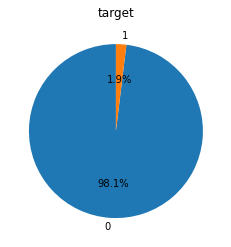

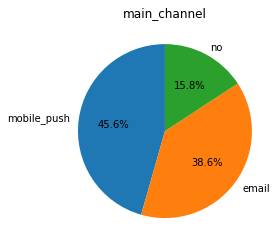

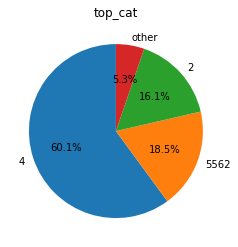

In [64]:
for col in cat_cols:
    circle(full, col, title=col, cycle=None)

**Видно, что для целевого признака наблюдается сильный дисбаланс классов. При разбиении на выборки буду использовать стратификацию.**

**Построю круговые диаграммы по срезам.**

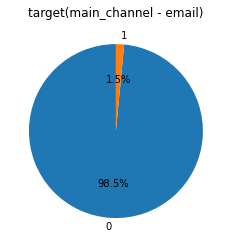

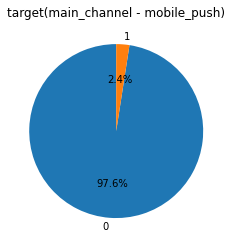

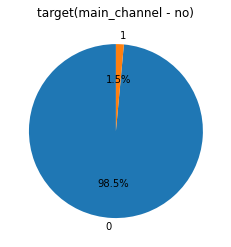

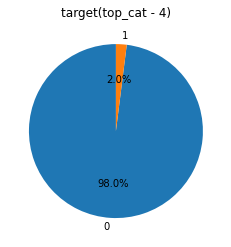

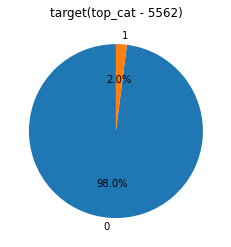

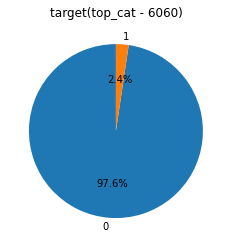

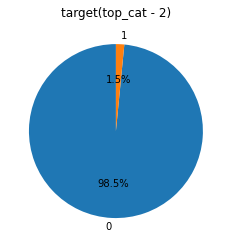

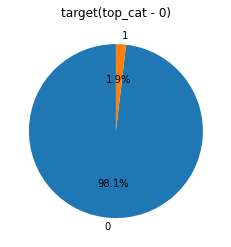

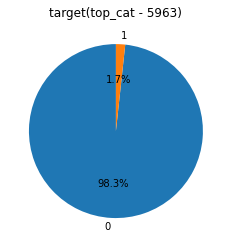

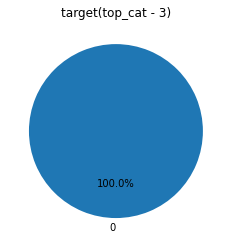

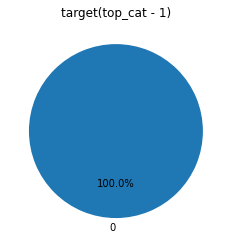

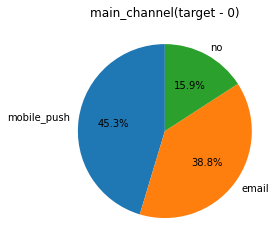

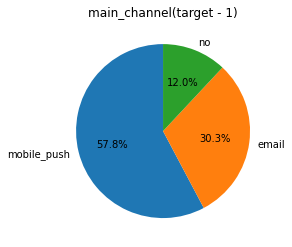

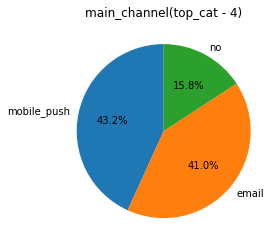

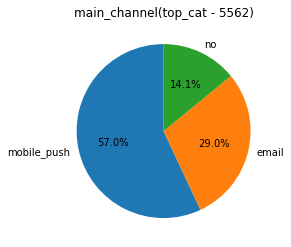

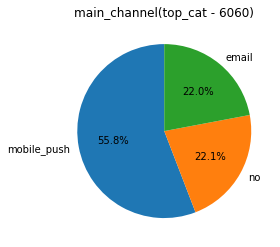

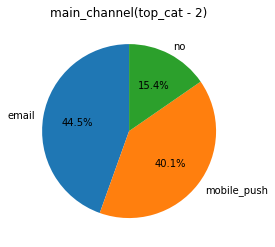

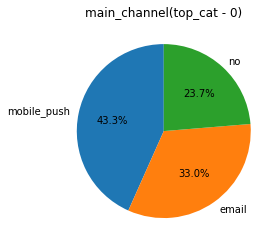

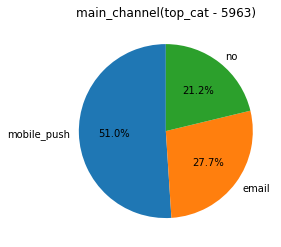

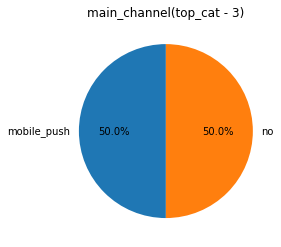

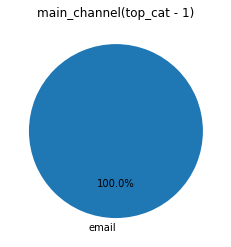

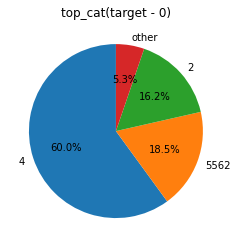

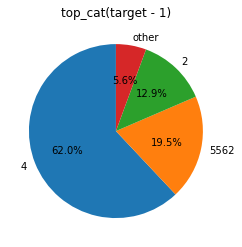

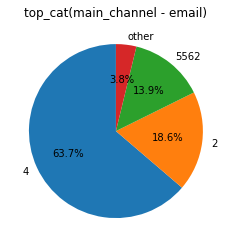

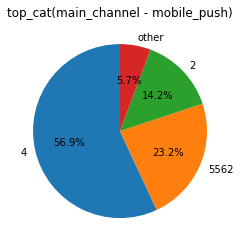

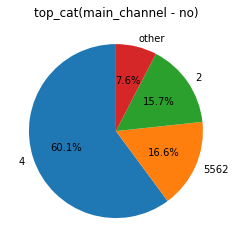

In [65]:
for col_1 in cat_cols:
    x=cat_cols.copy()
    x.remove(col_1)
    for col in x:
        circle(full, col_1, title=col_1, cycle=col)

**Интересно, что клиенты, которые интересуются определенными категориями товаров, преимущественно получают уведомления разными способами. Но поскольку категории обезличены, сложно это анализировать.**

**Напишу функцию, которая будет строить гистограммы и ящики с усами для количественных признаков по всему датасету и по срезам.**

In [66]:
def hist_box(data, column, bins=10, range=(0, 1000), title='', xlabel='', ylabel='', cycle=None):
    '''Функция строит гистограмму с указанным количеством корзин, заголовком и подписями осей, а также 'ящики с усами' 
    по заданному столбцу из датасета по генеральной выборке и по срезам (указываются в параметре cycle)'''
    if cycle==None:
        plt.hist(data[column], bins=bins, color='darkblue', range=range)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.show()
        data_1=data[column].reset_index(drop=True)
        sns.boxplot(data=data_1)
        plt.title(title+' boxplot')
        plt.show()
    else:
        colors=['b', 'g', 'r', 'c', 'm', 'y', 'k']*7
        for i in data[cycle].unique():
            plt.hist(data[data[cycle]==i][column], bins=bins, range=range, color=colors[list(data[cycle].unique()).index(i)])
            plt.title(title+' ('+cycle+' - '+str(i)+')')
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            plt.show()
            data_1=data[data[cycle]==i][column].reset_index(drop=True)
            sns.boxplot(data=data_1)
            plt.title(title+' ('+cycle+' - '+str(i)+')'+' boxplot')
            plt.show()

**Рассмотрю все количественные признаки по генеральной выборке и срезам по целевому признаку.**

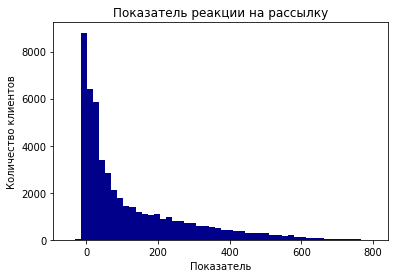

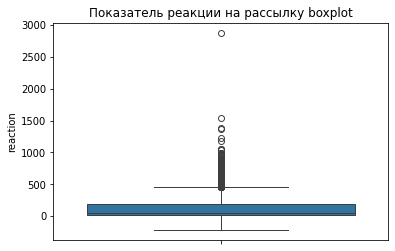

In [67]:
hist_box(data=full, column='reaction', bins=50, range=(-50, 800), title='Показатель реакции на рассылку', xlabel='Показатель',
         ylabel='Количество клиентов', cycle=None)

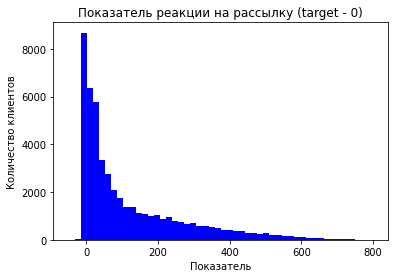

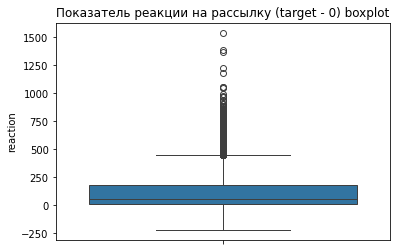

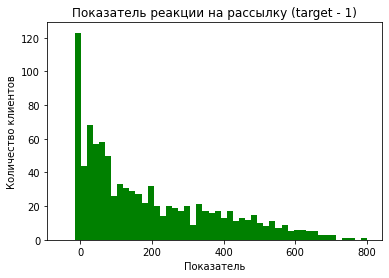

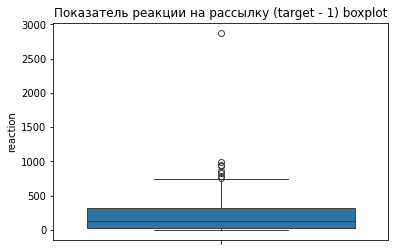

In [68]:
hist_box(data=full, column='reaction', bins=50, range=(-50, 800), title='Показатель реакции на рассылку', xlabel='Показатель',
         ylabel='Количество клиентов', cycle='target')

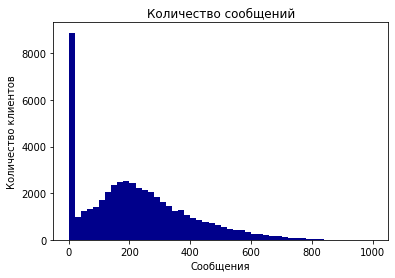

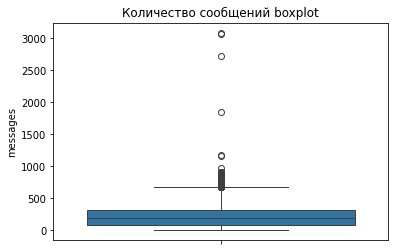

In [69]:
hist_box(data=full, column='messages', bins=50, range=(0, 1000), title='Количество сообщений', xlabel='Сообщения',
         ylabel='Количество клиентов', cycle=None)

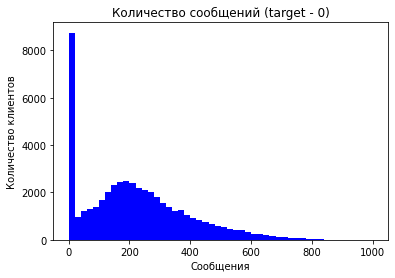

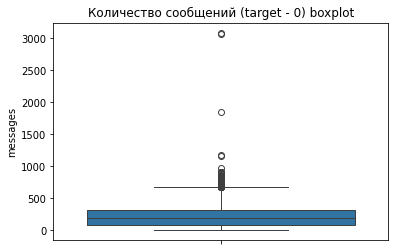

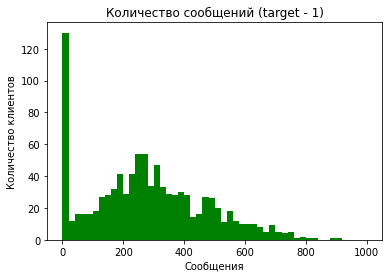

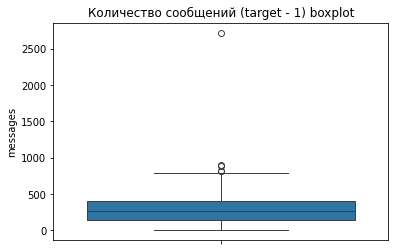

In [70]:
hist_box(data=full, column='messages', bins=50, range=(0, 1000), title='Количество сообщений', xlabel='Сообщения',
         ylabel='Количество клиентов', cycle='target')

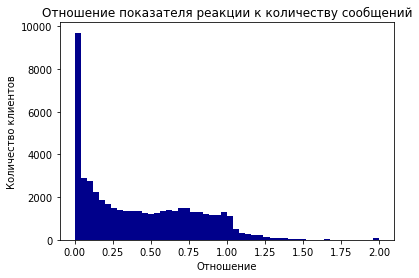

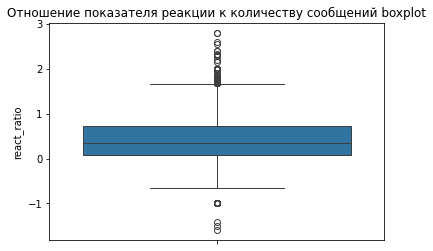

In [71]:
hist_box(data=full, column='react_ratio', bins=50, range=(0, 2),
         title='Отношение показателя реакции к количеству сообщений', xlabel='Отношение',
         ylabel='Количество клиентов', cycle=None)

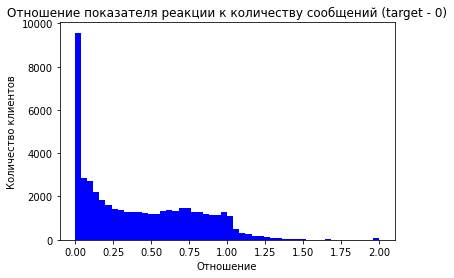

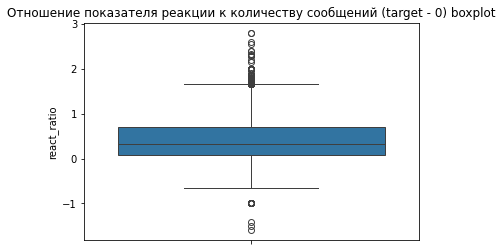

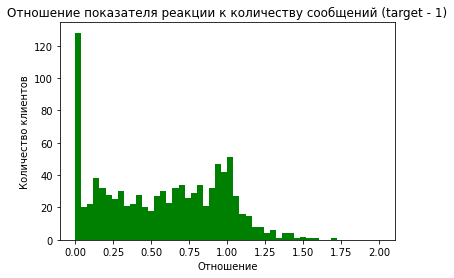

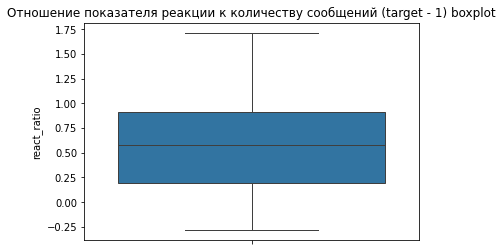

In [72]:
hist_box(data=full, column='react_ratio', bins=50, range=(0, 2),
         title='Отношение показателя реакции к количеству сообщений', xlabel='Отношение',
         ylabel='Количество клиентов', cycle='target')

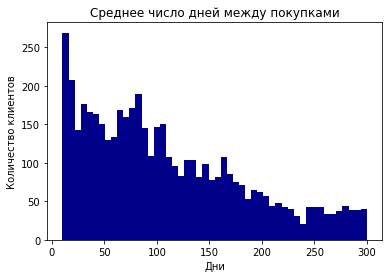

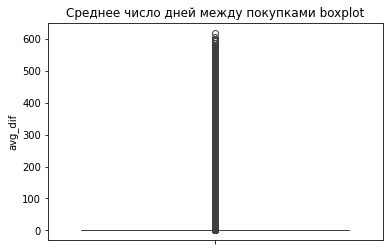

In [73]:
hist_box(data=full, column='avg_dif', bins=50, range=(10, 300),
         title='Среднее число дней между покупками', xlabel='Дни',
         ylabel='Количество клиентов', cycle=None)

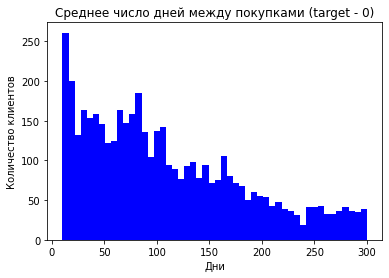

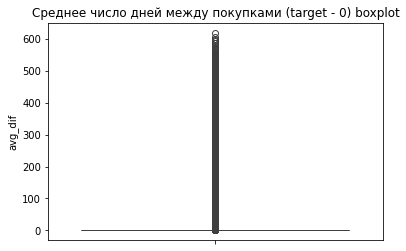

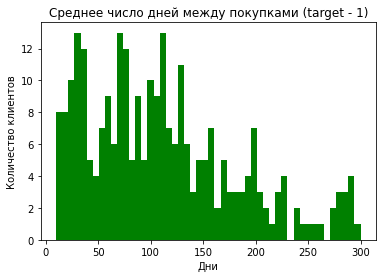

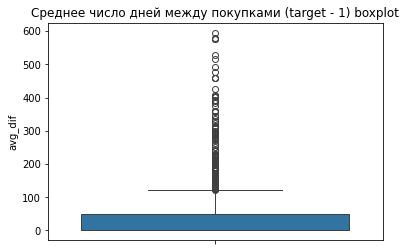

In [74]:
hist_box(data=full, column='avg_dif', bins=50, range=(10, 300),
         title='Среднее число дней между покупками', xlabel='Дни',
         ylabel='Количество клиентов', cycle='target')

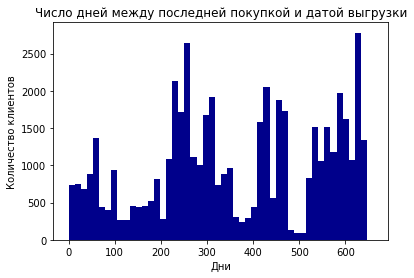

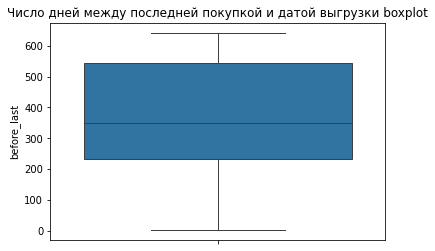

In [75]:
hist_box(data=full, column='before_last', bins=50, range=(0, 660),
         title='Число дней между последней покупкой и датой выгрузки', xlabel='Дни',
         ylabel='Количество клиентов', cycle=None)

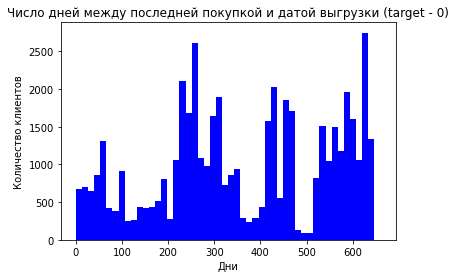

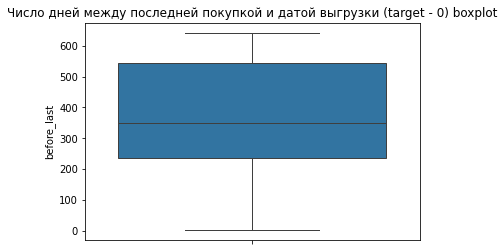

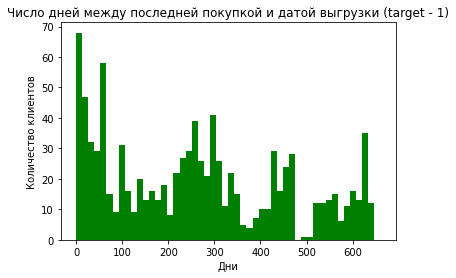

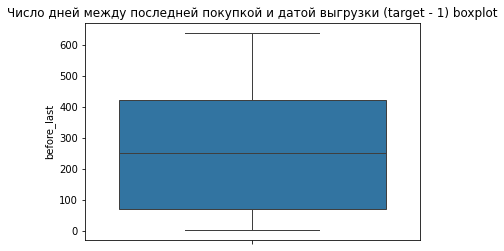

In [76]:
hist_box(data=full, column='before_last', bins=50, range=(0, 660),
         title='Число дней между последней покупкой и датой выгрузки', xlabel='Дни',
         ylabel='Количество клиентов', cycle='target')

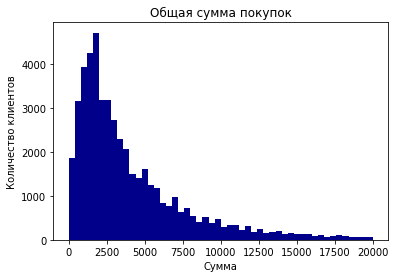

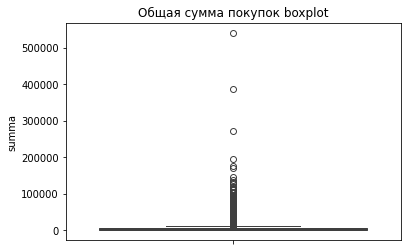

In [77]:
hist_box(data=full, column='summa', bins=50, range=(0, 20000),
         title='Общая сумма покупок', xlabel='Сумма',
         ylabel='Количество клиентов', cycle=None)

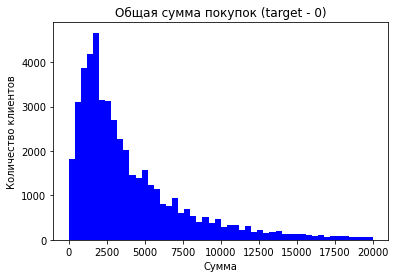

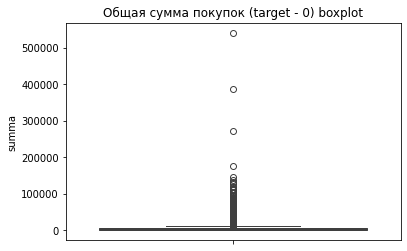

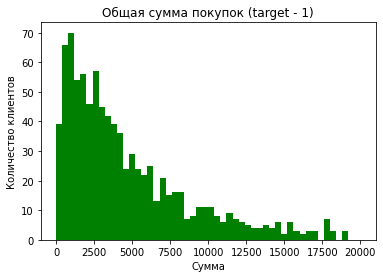

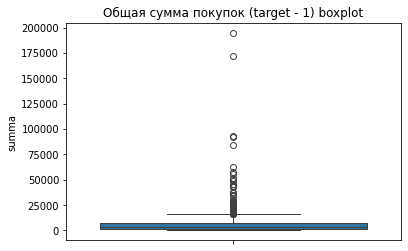

In [78]:
hist_box(data=full, column='summa', bins=50, range=(0, 20000),
         title='Общая сумма покупок', xlabel='Сумма',
         ylabel='Количество клиентов', cycle='target')

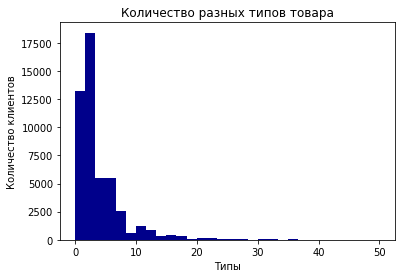

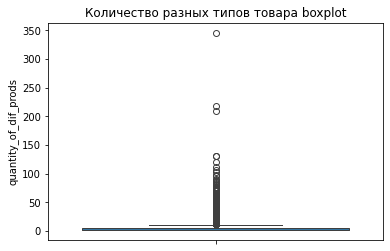

In [79]:
hist_box(data=full, column='quantity_of_dif_prods', bins=30, range=(0, 50),
         title='Количество разных типов товара', xlabel='Типы',
         ylabel='Количество клиентов', cycle=None)

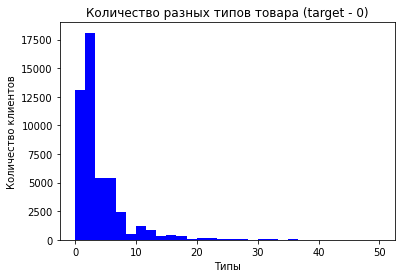

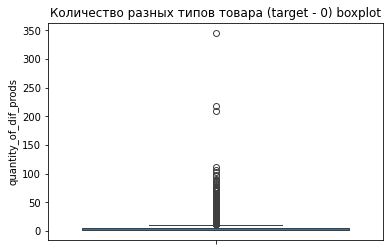

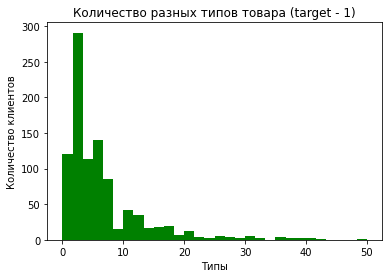

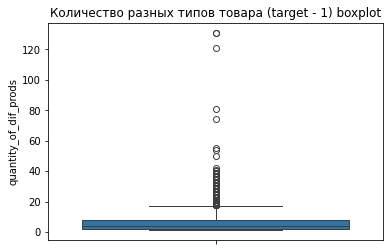

In [80]:
hist_box(data=full, column='quantity_of_dif_prods', bins=30, range=(0, 50),
         title='Количество разных типов товара', xlabel='Типы',
         ylabel='Количество клиентов', cycle='target')

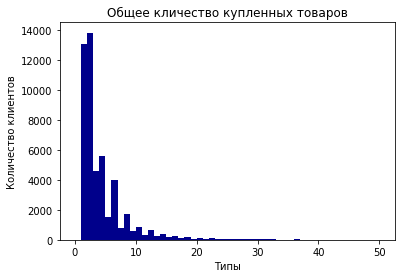

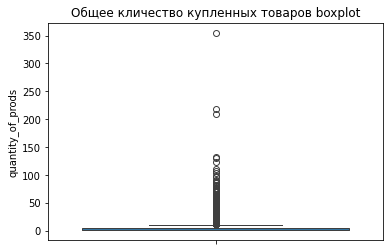

In [81]:
hist_box(data=full, column='quantity_of_prods', bins=50, range=(0, 50),
         title='Общее кличество купленных товаров', xlabel='Типы',
         ylabel='Количество клиентов', cycle=None)

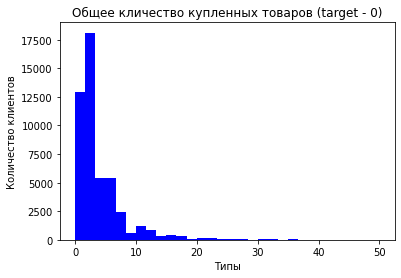

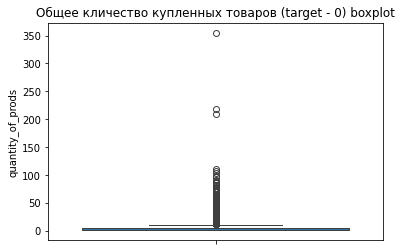

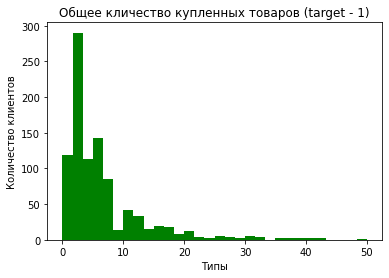

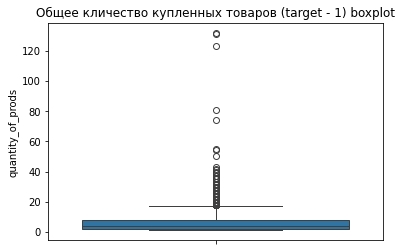

In [82]:
hist_box(data=full, column='quantity_of_prods', bins=30, range=(0, 50),
         title='Общее кличество купленных товаров', xlabel='Типы',
         ylabel='Количество клиентов', cycle='target')

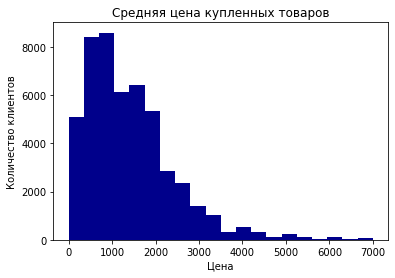

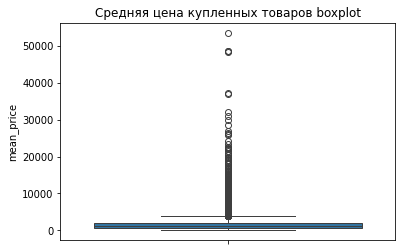

In [83]:
hist_box(data=full, column='mean_price', bins=20, range=(0, 7000),
         title='Средняя цена купленных товаров', xlabel='Цена',
         ylabel='Количество клиентов', cycle=None)

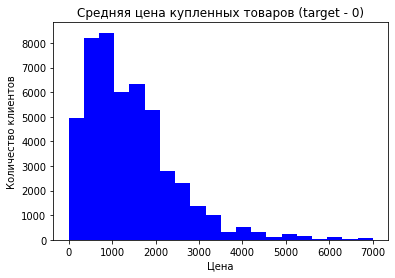

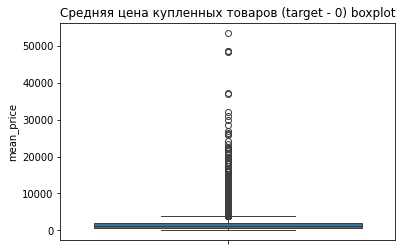

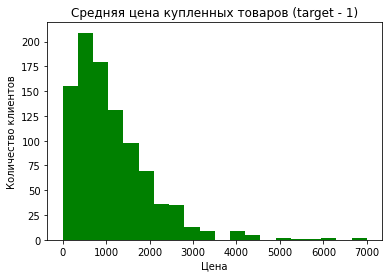

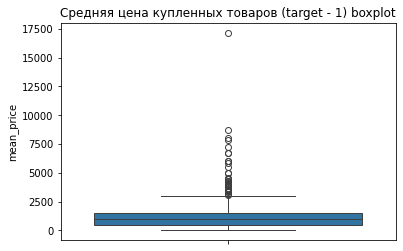

In [84]:
hist_box(data=full, column='mean_price', bins=20, range=(0, 7000),
         title='Средняя цена купленных товаров', xlabel='Цена',
         ylabel='Количество клиентов', cycle='target')

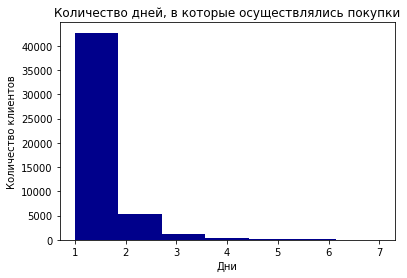

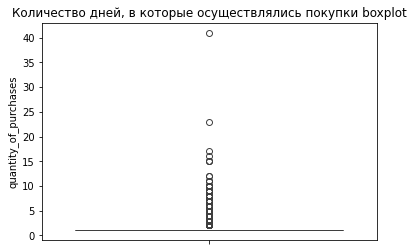

In [85]:
hist_box(data=full, column='quantity_of_purchases', bins=7, range=(1, 7),
         title='Количество дней, в которые осуществлялись покупки', xlabel='Дни',
         ylabel='Количество клиентов', cycle=None)

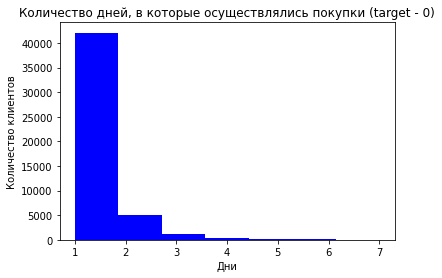

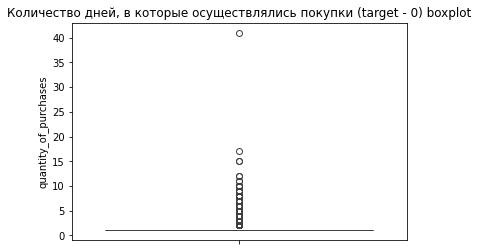

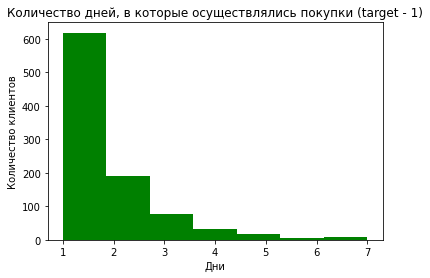

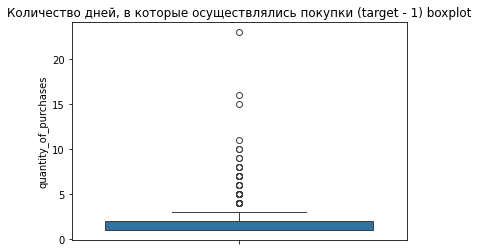

In [86]:
hist_box(data=full, column='quantity_of_purchases', bins=7, range=(1, 7),
         title='Количество дней, в которые осуществлялись покупки', xlabel='Дни',
         ylabel='Количество клиентов', cycle='target')

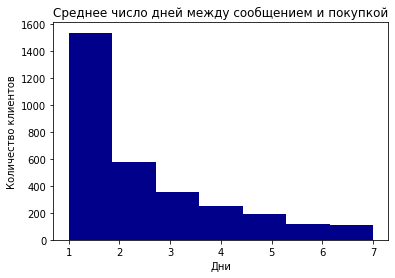

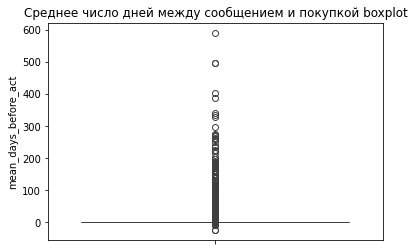

In [87]:
hist_box(data=full, column='mean_days_before_act', bins=7, range=(1, 7),
         title='Среднее число дней между сообщением и покупкой', xlabel='Дни',
         ylabel='Количество клиентов', cycle=None)

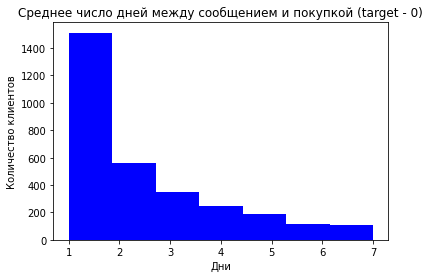

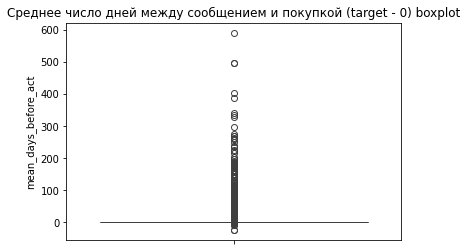

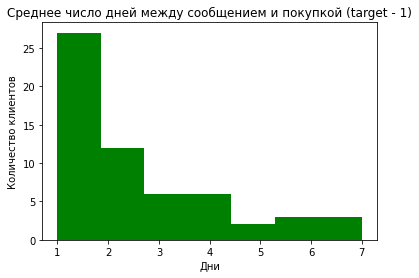

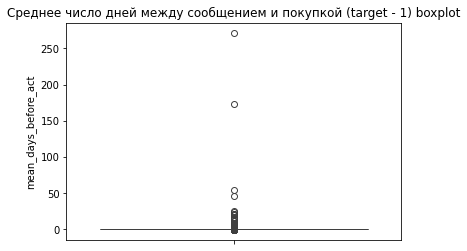

In [88]:
hist_box(data=full, column='mean_days_before_act', bins=7, range=(1, 7),
         title='Среднее число дней между сообщением и покупкой', xlabel='Дни',
         ylabel='Количество клиентов', cycle='target')

**В некоторых признаках наблюдаются аномально большие значения. Удалю их только если они в срезе целевого признака=0.**

In [89]:
full_1=full.query('messages<1900 & summa<250000 & quantity_of_dif_prods<150 & mean_price<40000\
                  & quantity_of_purchases<25 & mean_days_before_act<450')
full_1.info()
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49834 entries, 1515915625468060902 to 1515915626010443624
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   reaction               49834 non-null  float64
 1   messages               49834 non-null  float64
 2   main_channel           49834 non-null  object 
 3   avg_dif                49834 non-null  float64
 4   before_last            49834 non-null  int64  
 5   summa                  49834 non-null  float64
 6   quantity_of_dif_prods  49834 non-null  int64  
 7   quantity_of_prods      49834 non-null  int64  
 8   mean_price             49834 non-null  float64
 9   quantity_of_purchases  49834 non-null  int64  
 10  top_cat                49834 non-null  object 
 11  mean_days_before_act   49834 non-null  float64
 12  target                 49834 non-null  int64  
 13  react_ratio            49834 non-null  float64
dtypes: float64(7), int64(5

**Удалено всего 15 значений, что не портит датасет.**

In [90]:
full_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49834 entries, 1515915625468060902 to 1515915626010443624
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   reaction               49834 non-null  float64
 1   messages               49834 non-null  float64
 2   main_channel           49834 non-null  object 
 3   avg_dif                49834 non-null  float64
 4   before_last            49834 non-null  int64  
 5   summa                  49834 non-null  float64
 6   quantity_of_dif_prods  49834 non-null  int64  
 7   quantity_of_prods      49834 non-null  int64  
 8   mean_price             49834 non-null  float64
 9   quantity_of_purchases  49834 non-null  int64  
 10  top_cat                49834 non-null  object 
 11  mean_days_before_act   49834 non-null  float64
 12  target                 49834 non-null  int64  
 13  react_ratio            49834 non-null  float64
dtypes: float64(7), int64(5

In [91]:
full_1.columns

Index(['reaction', 'messages', 'main_channel', 'avg_dif', 'before_last',
       'summa', 'quantity_of_dif_prods', 'quantity_of_prods', 'mean_price',
       'quantity_of_purchases', 'top_cat', 'mean_days_before_act', 'target',
       'react_ratio'],
      dtype='object')

**Проведу корелляционный анализ созданных признаков.**

In [92]:
# создаём список с наименованиями количественных признаков
interval_cols = ['reaction', 'avg_dif', 'summa',  'mean_price', 'mean_days_before_act', 'react_ratio']

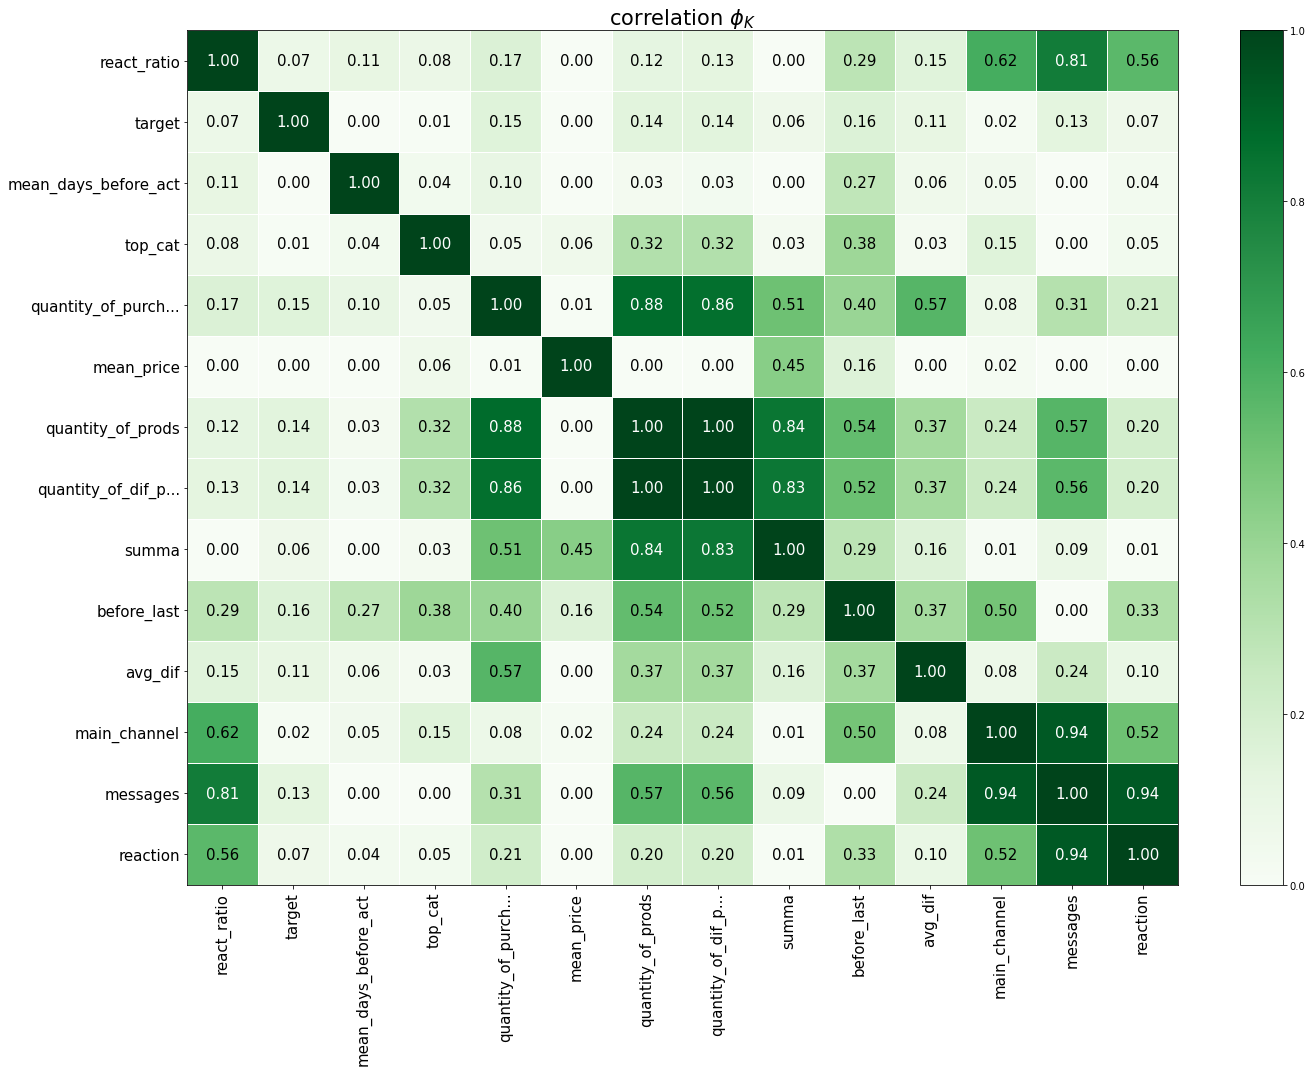

In [93]:
# считаем корреляции на тренировочной выборке
phik_overview = phik_matrix(full_1, interval_cols=interval_cols)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

**Удалю сильно коррелирующие признаки.**

In [94]:
full_1=full_1[['messages', 'avg_dif', 'before_last','react_ratio', 'quantity_of_prods', 'mean_price',
              'top_cat', 'mean_days_before_act', 'target']]
# создаём список с наименованиями количественных признаков
interval_cols = ['avg_dif', 'mean_price', 'mean_days_before_act', 'react_ratio']

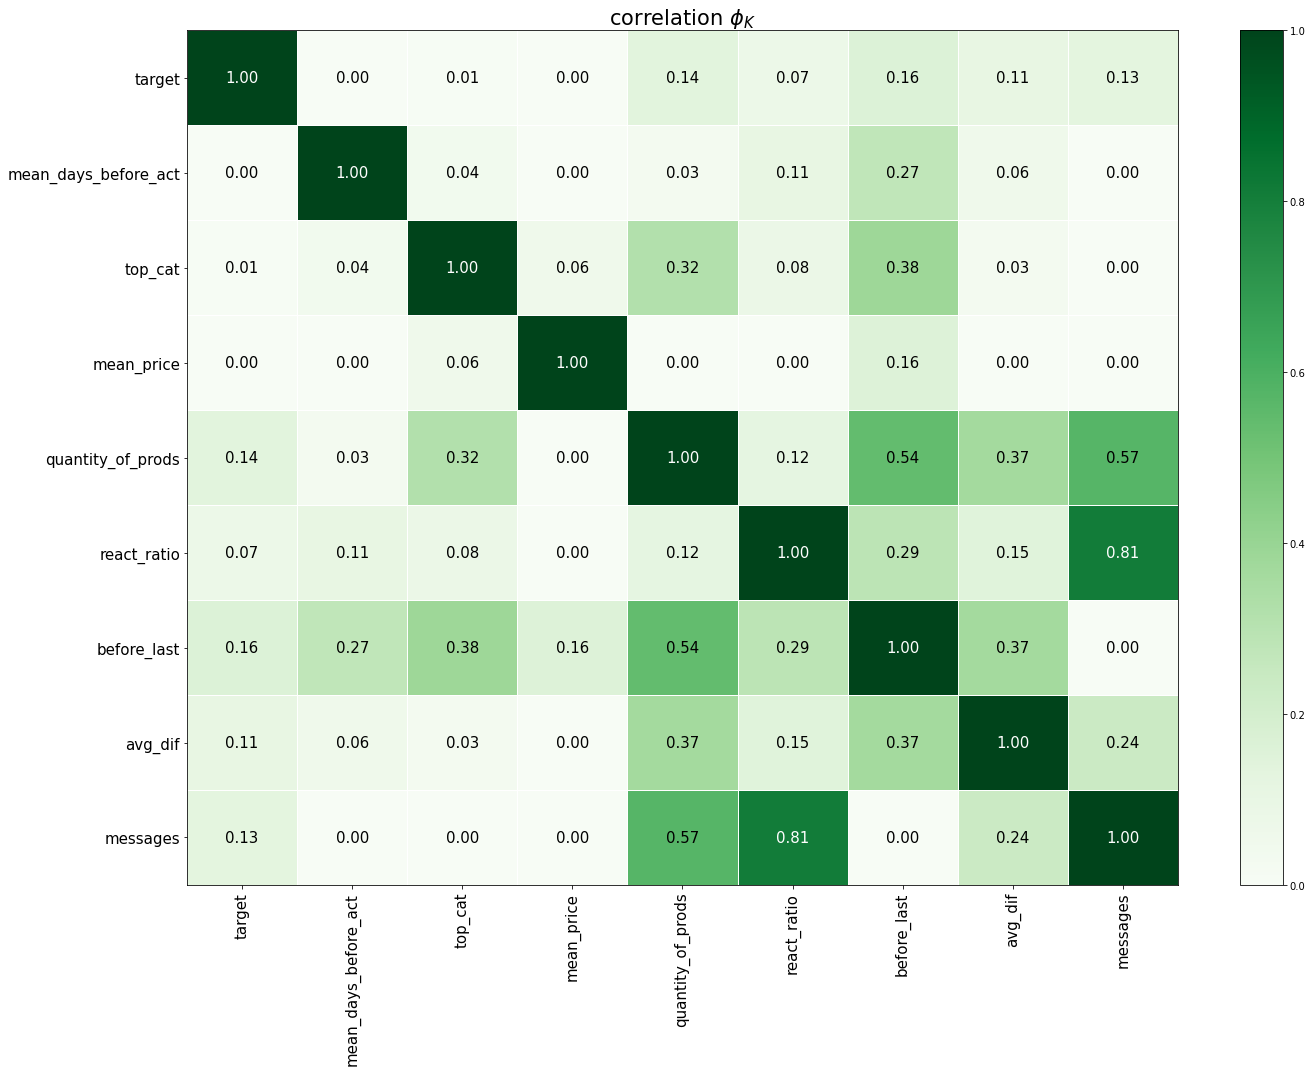

In [95]:
# считаем корреляции на тренировочной выборке
phik_overview = phik_matrix(full_1, interval_cols=interval_cols)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

**react_ratio и messages сильно кореллируют, но я проверял, если убрать один из них, это не сильно повлияет на результаты работы моделей. Утечки целевого признака не наблюдается.**

## Подготовка данных <a class="anchor" id="chapter4"></a>

**Поскольку остался только один категориальный признак, закодирую его вручную.**

In [96]:
full_1.top_cat.unique()

array(['4', '5562', '6060', '2', '0', '5963', '3', '1'], dtype=object)

In [97]:
def top_cat_(x):
    if x=='0':
        return 0
    elif x=='1':
        return 1
    elif x=='2':
        return 2
    elif x=='3':
        return 3
    elif x=='4':
        return 4
    elif x=='5562':
        return 5
    elif x=='5963':
        return 6
    else:
        return 7

In [98]:
full_1['top_cat']=full_1['top_cat'].apply(top_cat_)

In [99]:
#Разбиваю признаки на нецелевые и целевой
X = full_1.drop('target', axis=1)
y = full_1.target
#Разбиваю выборку на тренировочную и валидационную
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.25, 
    random_state = RANDOM_STATE,
    stratify=y) #Использую стратификацию

In [100]:
num_columns = ['messages', 'avg_dif', 'before_last','react_ratio', 'quantity_of_prods', 'mean_price', 'mean_days_before_act']

#Выполню кодировку и масштабирование данных в одном ColumnTransformer 
ct_prep = ColumnTransformer(
    [
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

## Обучение моделей <a class="anchor" id="chapter5"></a>

**Реализую поиск лучшей модели с лучшими параметрами через рандомизированный поиск. Объединю подготовку данных и работу моделей в пайплайн.**

In [101]:
param_grid_DTC = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 20),
        'models__min_samples_split': range(2, 10),
        'models__min_samples_leaf': range(1, 10),
        'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }]

#В финальном пайплайне объединю подготовку данных и работу моделей
pipe_final=Pipeline([
    ('preprocessor', ct_prep),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

#Для ускорения процесса воспользуюсь рандомизированным поиском
grid_DTC = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_grid_DTC, 
    cv=5, 
    scoring='roc_auc',
    n_iter = 30,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
grid_DTC.fit(X_train, y_train)

print('Параметры лучшей модели:\n\n', grid_DTC.best_estimator_)
print ('Метрика ROC-AUC лучшей модели на тренировочной выборке:', grid_DTC.best_score_)

Параметры лучшей модели:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['messages', 'avg_dif',
                                                   'before_last', 'react_ratio',
                                                   'quantity_of_prods',
                                                   'mean_price',
                                                   'mean_days_before_act'])])),
                ('models',
                 DecisionTreeClassifier(max_depth=5, max_features=9,
                                        min_samples_leaf=2, min_samples_split=7,
                                        random_state=42))])
Метрика ROC-AUC лучшей модели на тренировочной выборке: 0.6942922179784476


**Лучшими гиперпараметрами оказались DecisionTreeClassifier(max_depth=5, max_features=9, min_samples_leaf=2, min_samples_split=7, random_state=42), лучшим скейлером - StandardScaler. Значение метрики ROC-AUC немного не дотягивает до условия (>0.7).**

In [102]:
model_DTC = grid_DTC.best_estimator_
start = time()
model_DTC.fit(X_train, y_train)
end = time()
model_DTC_fit_time = end-start #замеряем время обучения

start = time()
model_DTC.predict(X_train)
end = time()
model_DTC_predict_time = end-start #замеряем время предсказания
print('model_DTC_fit_time = ', model_DTC_fit_time, ' s')
print('model_DTC_predict_time = ', model_DTC_predict_time, ' s')

model_DTC_fit_time =  0.08134984970092773  s
model_DTC_predict_time =  0.007991790771484375  s


In [103]:
param_grid_LR = [
    {
        'models': [LogisticRegression()],
        'models__C': np.arange(0.5, 5, 0.5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    }]

#В финальном пайплайне объединю подготовку данных и работу моделей
pipe_final=Pipeline([
    ('preprocessor', ct_prep),
    ('models', LogisticRegression())
])

#Параметров немного, поэтому использую поиск по сетке
grid_LR = GridSearchCV(
    pipe_final, 
    param_grid=param_grid_LR, 
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1
)
grid_LR.fit(X_train, y_train)

print('Параметры лучшей модели:\n\n', grid_LR.best_estimator_)
print ('Метрика ROC-AUC лучшей модели на тренировочной выборке:', grid_LR.best_score_)

Параметры лучшей модели:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', RobustScaler(),
                                                  ['messages', 'avg_dif',
                                                   'before_last', 'react_ratio',
                                                   'quantity_of_prods',
                                                   'mean_price',
                                                   'mean_days_before_act'])])),
                ('models', LogisticRegression(C=2.5))])
Метрика ROC-AUC лучшей модели на тренировочной выборке: 0.713690909228694


C:\Users\User\practicum\practicum_env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Лучшими гиперпараметрами оказались LogisticRegression(C=2.5), лучшим скейлером - StandardScaler. Значение метрики ROC-AUC удовлетворяет условию (>0.7).**

In [104]:
model_LR = grid_LR.best_estimator_
start = time()
model_LR.fit(X_train, y_train)
end = time()
model_LR_fit_time = end-start #замеряем время обучения

start = time()
model_LR.predict(X_train)
end = time()
model_LR_predict_time = end-start #замеряем время предсказания
print('model_LR_fit_time = ', model_LR_fit_time, ' s')
print('model_LR_predict_time = ', model_LR_predict_time, ' s')

model_LR_fit_time =  0.20649194717407227  s
model_LR_predict_time =  0.008388996124267578  s


C:\Users\User\practicum\practicum_env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [105]:
params = [
    # словарь для модели LGBMClassifier()
    {
        'models': [LGBMClassifier()],
        'models__num_leaves': range(20, 40),
        'models__learning_rate': np.arange(0.05, 0.25, 0.05),
        'models__n_estimators': range(90, 110),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }]
pipe_final_b=Pipeline([
    ('preprocessor', ct_prep),
    ('models', LGBMClassifier())
])

grid = RandomizedSearchCV(
    pipe_final_b, 
    param_distributions=params, 
    cv=5, 
    scoring='roc_auc',
    n_iter = 30,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
grid.fit(X_train, y_train)

print('Параметры лучшей модели:\n\n', grid.best_estimator_)
print ('Метрика ROC-AUC лучшей модели на тренировочной выборке:', grid.best_score_)

Параметры лучшей модели:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['messages', 'avg_dif',
                                                   'before_last', 'react_ratio',
                                                   'quantity_of_prods',
                                                   'mean_price',
                                                   'mean_days_before_act'])])),
                ('models',
                 LGBMClassifier(learning_rate=0.05, n_estimators=99,
                                num_leaves=32))])
Метрика ROC-AUC лучшей модели на тренировочной выборке: 0.7115737583170403


In [106]:
model_LGBM = grid.best_estimator_
start = time()
model_LGBM.fit(X_train, y_train)
end = time()
model_LGBM_fit_time = end-start #замеряем время обучения

start = time()
model_LGBM.predict(X_train)
end = time()
model_LGBM_predict_time = end-start #замеряем время предсказания
print('model_LGBM_fit_time = ', model_LGBM_fit_time, ' s')
print('model_LGBM_predict_time = ', model_LGBM_predict_time, ' s')

model_LGBM_fit_time =  0.2732853889465332  s
model_LGBM_predict_time =  0.07386016845703125  s


**Результат по метрике ROC-AUC для градиентного бустинга оказался немного хуже, чем для модели логистической регрессии. При этом обучение и предсказание идут дольше.**

**Для проверки адекватности моделей пропущу этот датасет через DummyRegressor cо стандартными параметрами.**

In [110]:
model_dummy = DummyClassifier()
model_dummy.fit(X_train, y_train)
probabilities = model_dummy.predict_proba(X_test)
probabilities_one = probabilities[:, 1]
print('Dummy ROC-AUC на тестовой выборке = ', roc_auc_score(y_test, probabilities_one))

Dummy ROC-AUC на тестовой выборке =  0.5


**Метрика ROC-AUC на DummyClassifier = 0.5, а это значит, что модели работают хорошо.**

**Сравнительная таблица моделей.**

In [108]:
table=pd.DataFrame(
    {'parameter':['ROC-AUC', 'Время обучения', 'Время предсказания'],
     'DecisionTreeClassifier': [grid_DTC.best_score_, round(model_DTC_fit_time, 3), round(model_DTC_predict_time, 3)],
     'LogisticRegression': [grid_LR.best_score_, round(model_LR_fit_time, 3), round(model_LR_predict_time, 3)],
     'LGBMClassifier': [grid.best_score_, round(model_LGBM_fit_time, 3), round(model_LGBM_predict_time, 3)]})
table

,parameter,DecisionTreeClassifier,LogisticRegression,LGBMClassifier
0,ROC-AUC,0.694292,0.713691,0.711574
1,Время обучения,0.081000,0.206000,0.273000
2,Время предсказания,0.008000,0.008000,0.074000


**По точности и времени работы лидирует модель логистической регрессии, поэтому применим ее к тестовой выборке.**

In [109]:
probabilities = model_LR.predict_proba(X_test)
probabilities_one = probabilities[:, 1]
print('LogisticRegression ROC-AUC на тестовой выборке = ', roc_auc_score(y_test, probabilities_one))

LogisticRegression ROC-AUC на тестовой выборке =  0.7304542788553345


**Результат близкий к значению по кросс-валидации на тренировочной выборке (даже выше). Переобучения не наблюдается.**

## Анализ моделей. Общий вывод. <a class="anchor" id="chapter6"></a>

**В результате работы над проектом были проанализированы данные из интернет-магазина. Целью работы было на основе предоставленных данных создать признаки, которые помогут обучить модели так, чтобы они могли предсказывать, купит ли этот клиент что-либо в течение следующих 90 дней.
В ходе работы:**
- Были открыты и предварительно изучен датасеты.
- Созданы новые признаки на основе данных по покупкам и рассылкам. Проведена агрегация данных.
- Устранены пропуски в данных и аномалии.
- Проведен исследовательский и корреляционный анализ данных.
- Отобраны важные для обучения моделей признаки, кототрые слабо коррелируют между собой.
- Проведена подготовка данных: кодирование категориального признака и масштабирование количественных.
- Обучены модели дерева решений и логистической регрессии. 
- С помощью рандомизированного поиска была выбраны лучшие модели дерева решений и логистической регрессии с оптимальными гиперпараметрами, которые показали лучшие значения метрики ROC-AUC.
- Также была обучена модель градиентного бустинга LGBMClassifier и с помощью рандомизированного поиска подобраны лучшие гиперпараметры для нее. 
- По результатам сравнения моделей, можно сделать вывод, что лучшие предсказательные результаты демонстрирует модель логистической регрессии. Кроме того эта модель примерно быстрее других.
- Лучшая модель была применена для предсказания по тестовой выборке. Результат по метрике ROC-AUC 0.73, что удовлетворяет требованиям.